In [1]:
using Interpolations
using ProfileView
using ForwardDiff
using PyPlot
using FixedSizeArrays

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
include("Acrobots/src/Acrobots.jl")

Acrobots

In [5]:
xdes = Acrobots.DoubleIntegratorState{Float64}(1, 0)
x0 = Acrobots.DoubleIntegratorState{Float64}([0; 0])
robot = Acrobots.double_integrator()
input = Acrobots.DoubleIntegratorInput{Float64}(0)
dt = 0.001
ts = 0:dt:2
Qf = diagm([1.,1])
Rf = 1e-6*eye(1)
Qt = diagm([0, 0.])

function state_cost(state::Acrobots.DoubleIntegratorState)
    x = convert(Vector, state - xdes)
    return 0.5*(x' * Qt * x)[1]
end
function input_cost(input::Acrobots.DoubleIntegratorInput)
    return Rf[1,1] * 0.5*input.u^2
end
S_final = Mat(Qf)

controller_state = Acrobots.LQRState{Float64}(())
linear_sys = Acrobots.linearize(robot, 0, x0, input)
controller = Acrobots.lqr(linear_sys, Qf, Rf, x0)
linearizations = Acrobots.simulate_and_linearize(robot, x0, controller, ts)

alpha = 0.5

for i = 1:10
    Qs, qs, Rs, rs = Acrobots.quadratize_costs(robot, ts, linearizations, state_cost, input_cost)
    Ks, ls = Acrobots.search_direction(robot, ts, linearizations, Qs, qs, Rs, rs, S_final, xdes)
    controller = Acrobots.update_controller(robot, ts, linearizations, Ks, ls, alpha)
    linearizations = Acrobots.simulate_and_linearize(robot, x0, controller, ts)

    
end

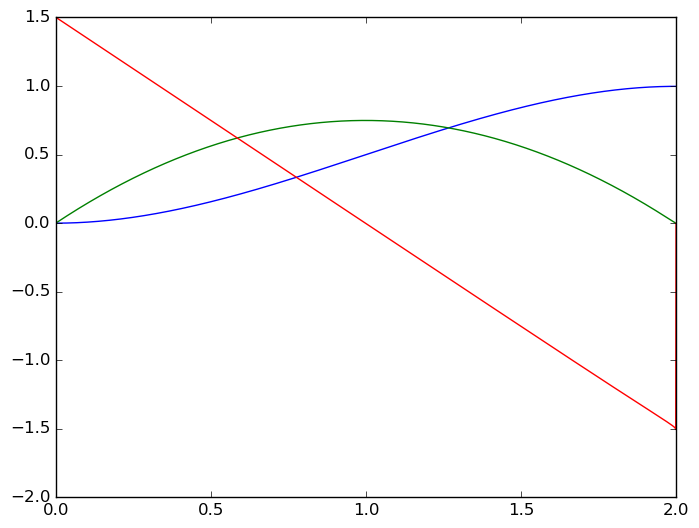

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc8dfc5fa10>
 PyObject <matplotlib.lines.Line2D object at 0x7fc8fb140290>
 PyObject <matplotlib.lines.Line2D object at 0x7fc8fb034a10>

In [9]:
plot(ts, [lin.x0[1] for lin in linearizations], ts, [lin.x0[2] for lin in linearizations],
ts, [lin.u0[1] for lin in linearizations])